In [3]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
import tqdm
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapezoid
from schwimmbad import MultiPool

In [4]:
e_grid = np.array([0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85])

e_lo_grid = np.array([0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1])
e_mid_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
e_mid_hi_grid = np.array([0.5, 0.6, 0.7])
e_hi_grid = np.array([0.7, 0.8, 0.85])
mass_grid = np.logspace(np.log10(5), np.log10(80), 15)
q_grid = np.linspace(0.1, 1, 15)
f_grid = np.logspace(-5, -1.0, 250)

In [11]:
M1, Q, E, F = np.meshgrid(mass_grid, q_grid, e_hi_grid, f_grid)

In [12]:
MC = lw.utils.chirp_mass(M1 * u.Msun, M1 * Q * u.Msun)
M2 = M1 * Q   

In [13]:
np.shape(F[:,:,:,:]), len(F.flatten())

((15, 15, 3, 250), 168750)

In [14]:
source = lw.source.Source(m_1=M1.flatten() * u.Msun,
                          m_2=M2.flatten() * u.Msun,
                          ecc=E.flatten(),
                          f_orb=F.flatten()*u.Hz,
                          dist=8 * np.ones(len(E.flatten())) * u.Mpc,
                          interpolate_g=True)
                                  
snr = source.get_snr(approximate_R=True, verbose=False)

In [15]:
snr_thresh = 12.0
D_horizon = snr / snr_thresh * 8 * u.Mpc
D_horizon = np.reshape(D_horizon, M1.shape)

In [16]:
dat_all = np.array([M1, M2, E, F, D_horizon.to(u.Mpc).value])
np.save('horizon_dat_e_hi', dat_all, allow_pickle=True)

In [9]:
M1, M2, E, F, D_horizon = dat_all

In [12]:
D_horizon = D_horizon * u.Mpc

0.001


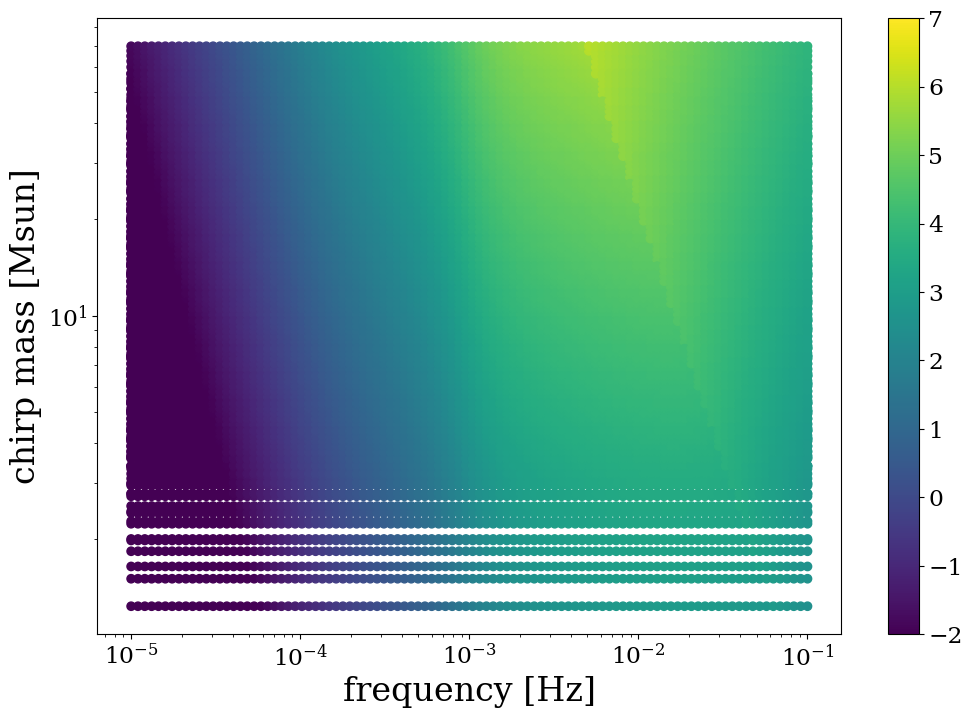

0.003


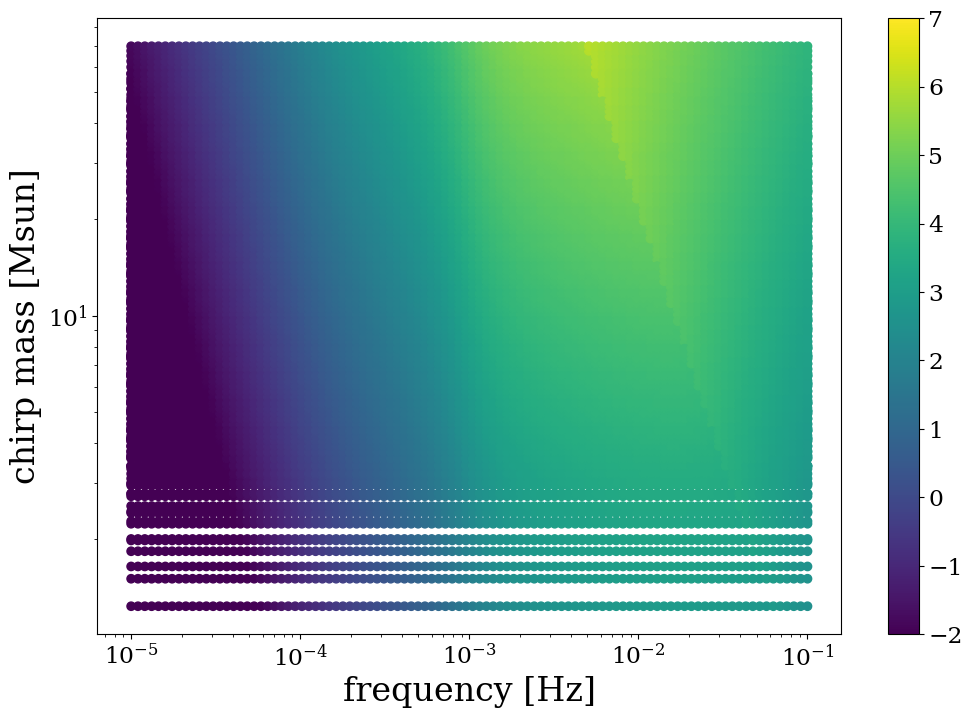

0.007


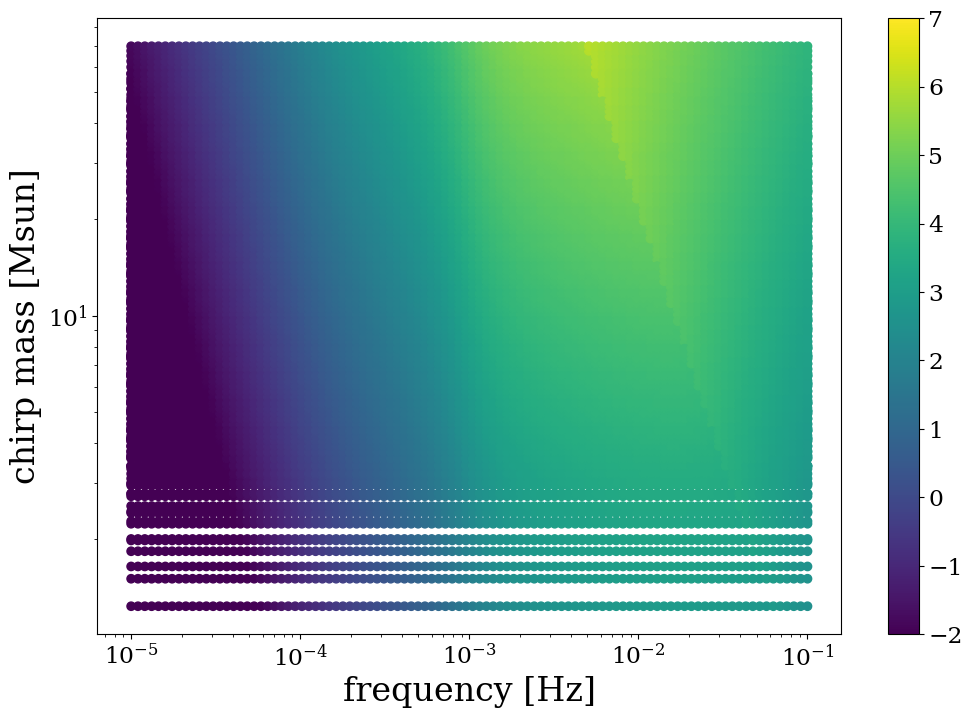

0.01


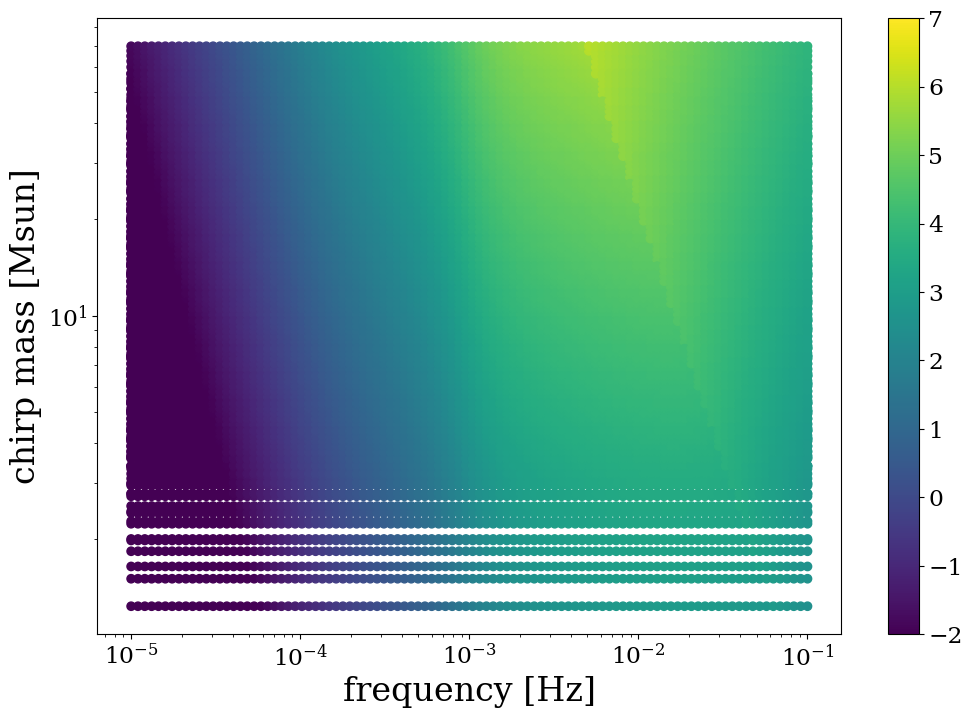

0.03


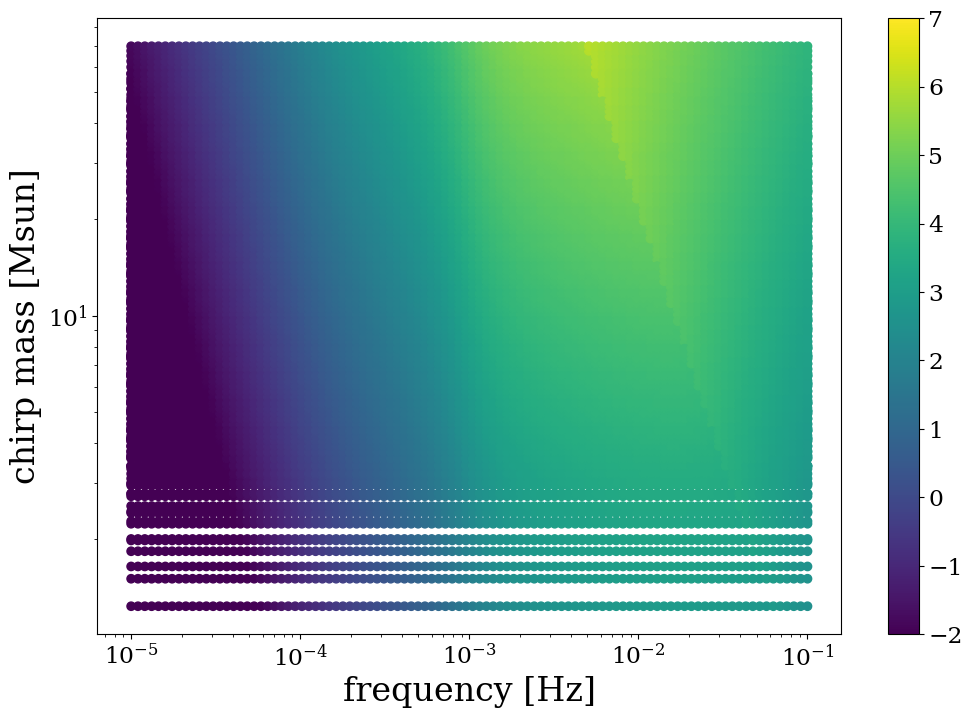

0.07


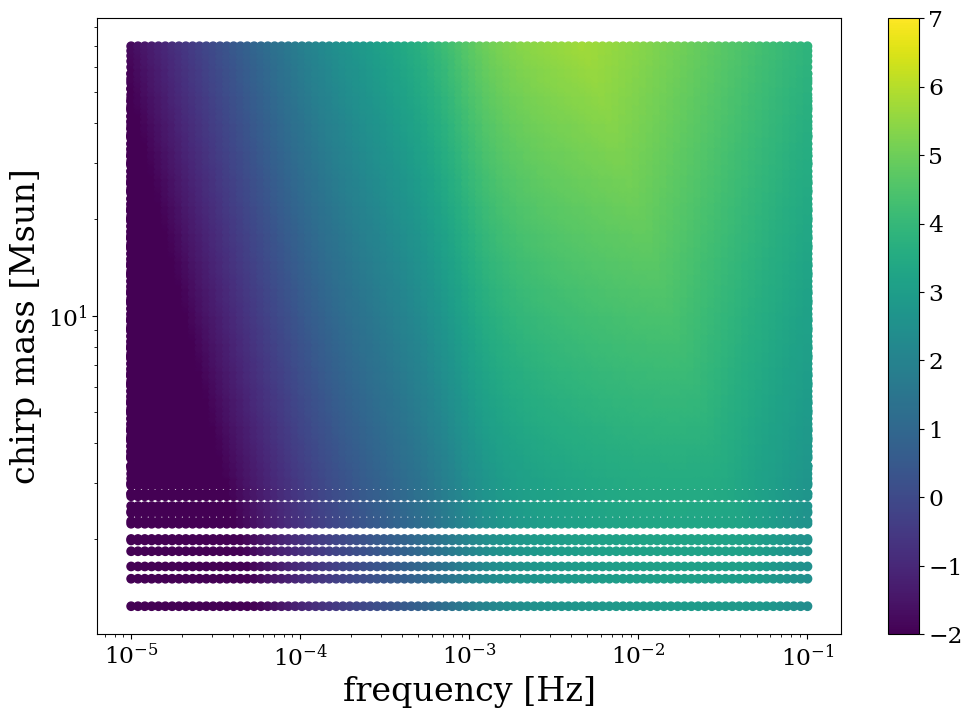

0.1


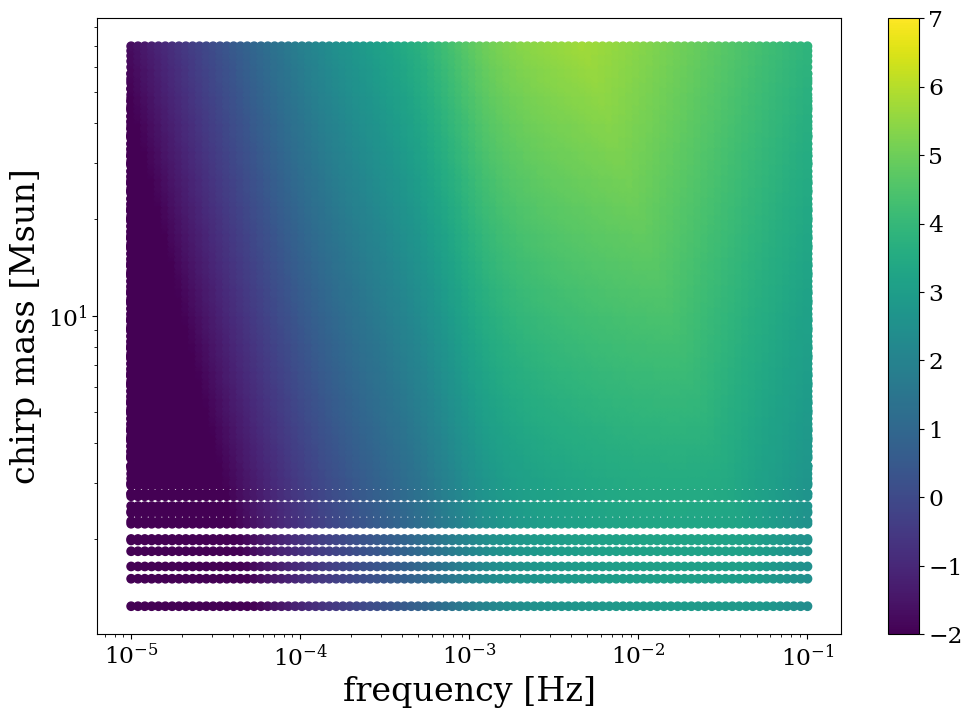

0.2


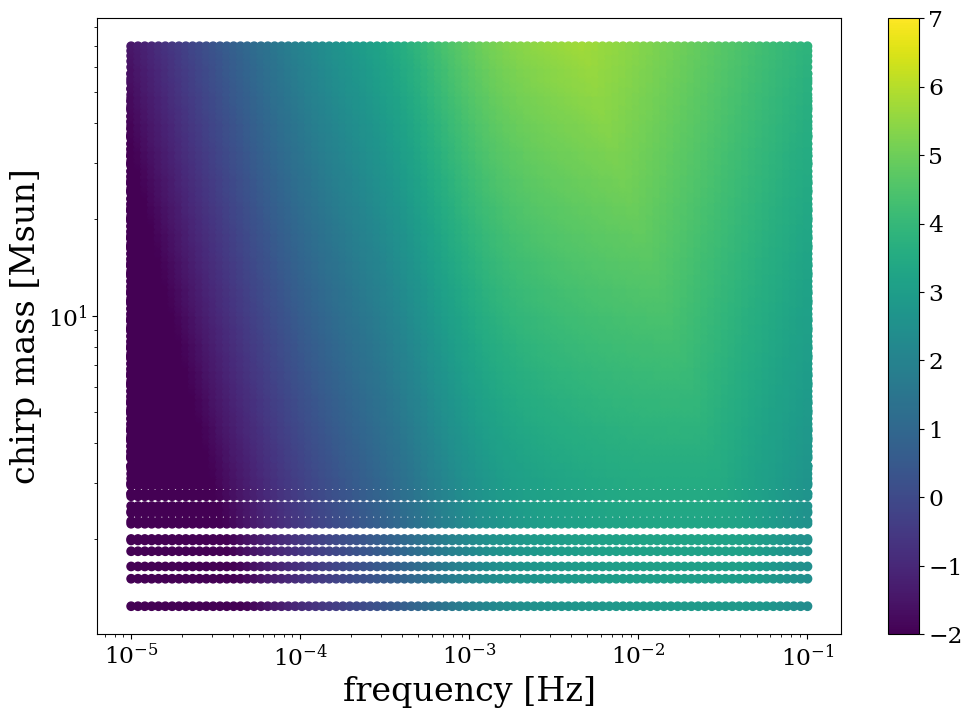

0.3


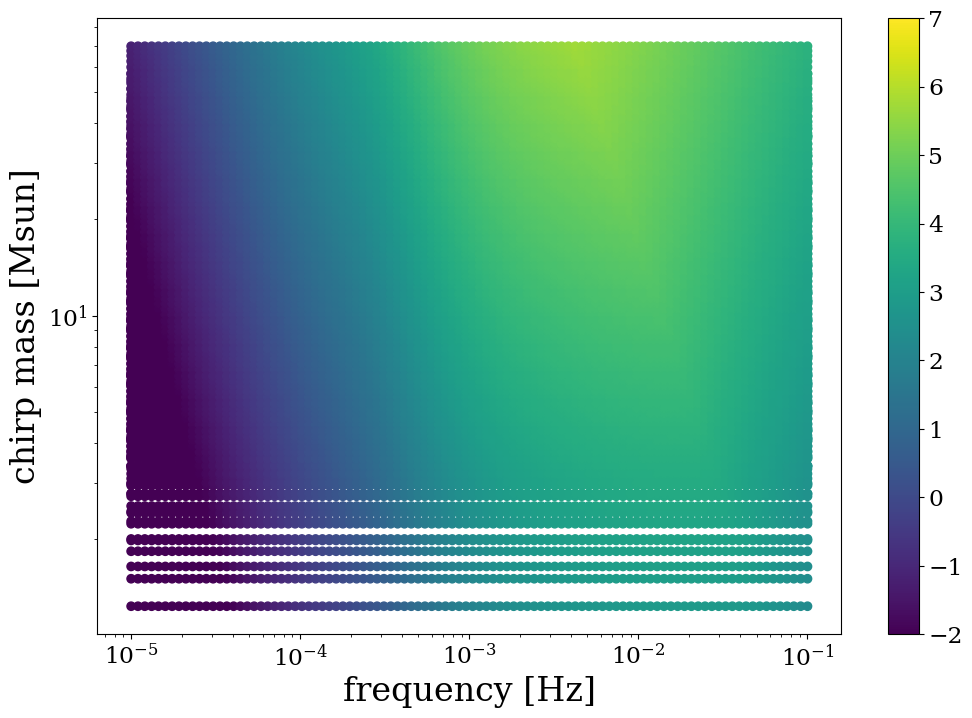

0.4


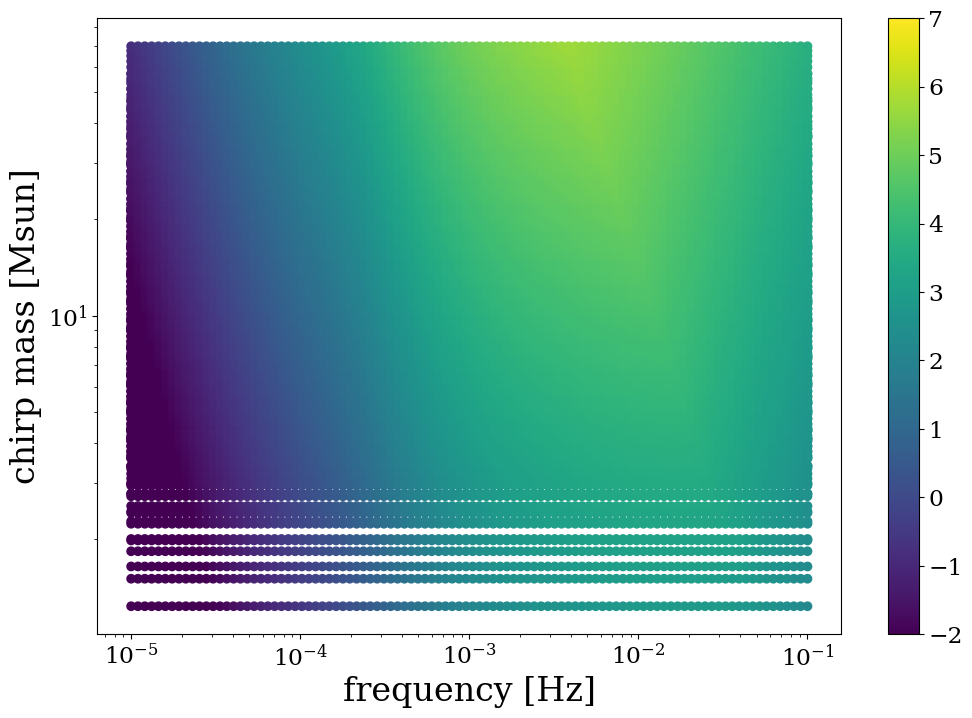

0.5


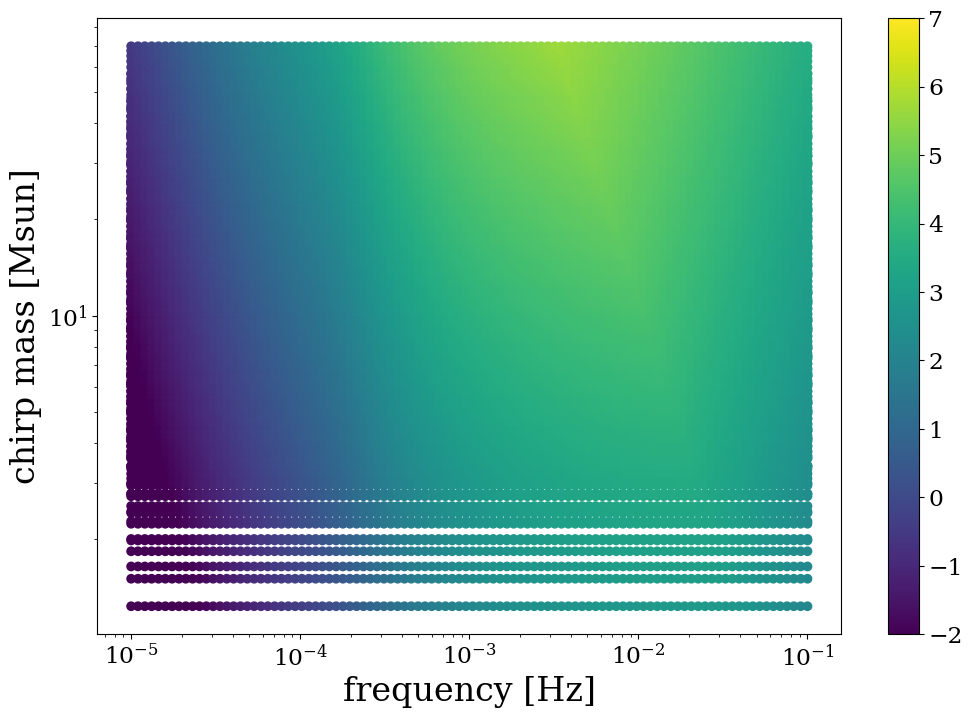

0.6


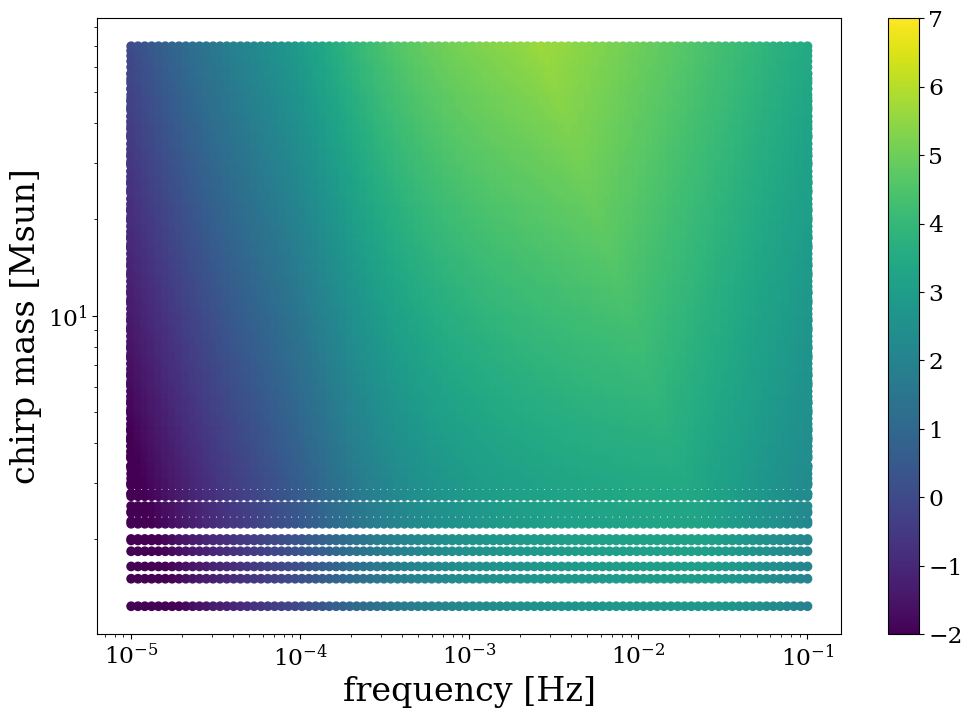

0.7


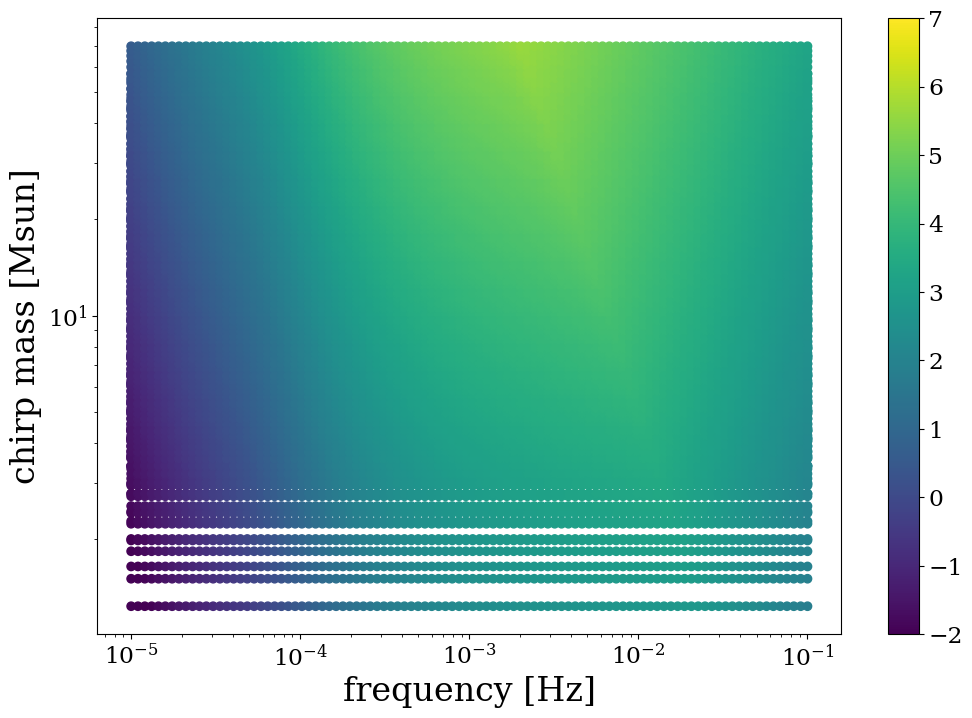

0.8


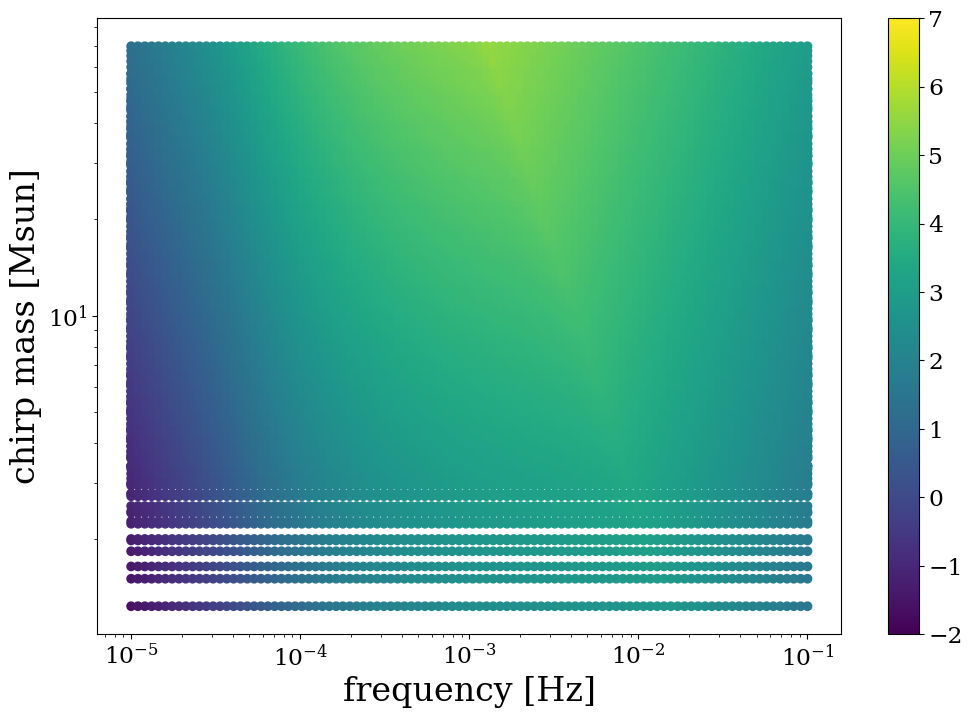

0.85


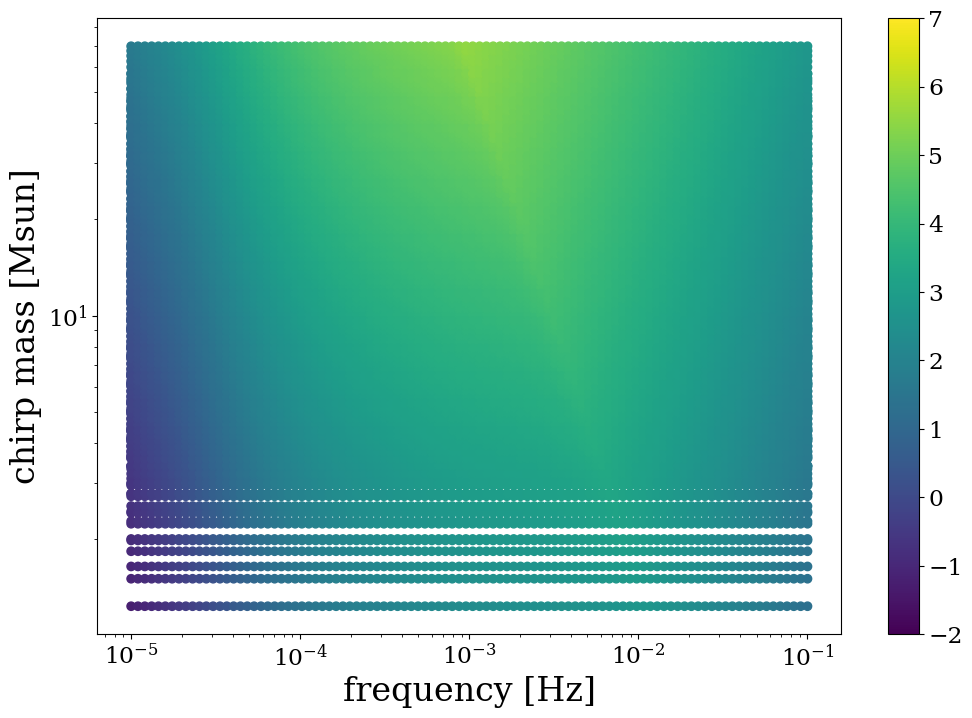

In [13]:
for ii in range(len(e_grid)):
    print(e_grid[ii])
    chirp_mass = lw.utils.chirp_mass(M1[:,:,ii,:] * u.Msun, M1[:,:,ii,:] * Q[:,:,ii,:] * u.Msun)
    plt.scatter(F[:,:,ii,:], chirp_mass, c=np.log10(D_horizon[:,:,ii,:].to(u.kpc).value), vmin=-2, vmax=7)
    plt.colorbar()
    plt.xscale('log')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('chirp mass [Msun]')
    plt.yscale('log')
    plt.show()

### Let's try a multivariate interpolation with nearest neighbors

In [14]:
from scipy.interpolate import NearestNDInterpolator

In [15]:
interp = NearestNDInterpolator(list(zip(MC.value.flatten(), F.flatten(), E.flatten())), D_horizon.value.flatten())

In [16]:
e_grid_test = np.logspace(-3, np.log10(1-0.12), 20)
mass_grid_test = np.logspace(np.log10(5), np.log10(80), 20)
q_grid_test = np.logspace(-1, 0, 30)
f_grid_test = np.logspace(-4.5, -1.5, 500)

In [17]:
M1_T, Q_T, E_T, F_T = np.meshgrid(mass_grid_test, q_grid_test, e_grid_test, f_grid_test)

In [18]:
len(E_T.flatten())

6000000

In [19]:
MC_T = lw.utils.chirp_mass(M1_T * u.Msun, M1_T * Q_T * u.Msun)


In [20]:
D_H_T = interp(MC_T, F_T, E_T)

0.001


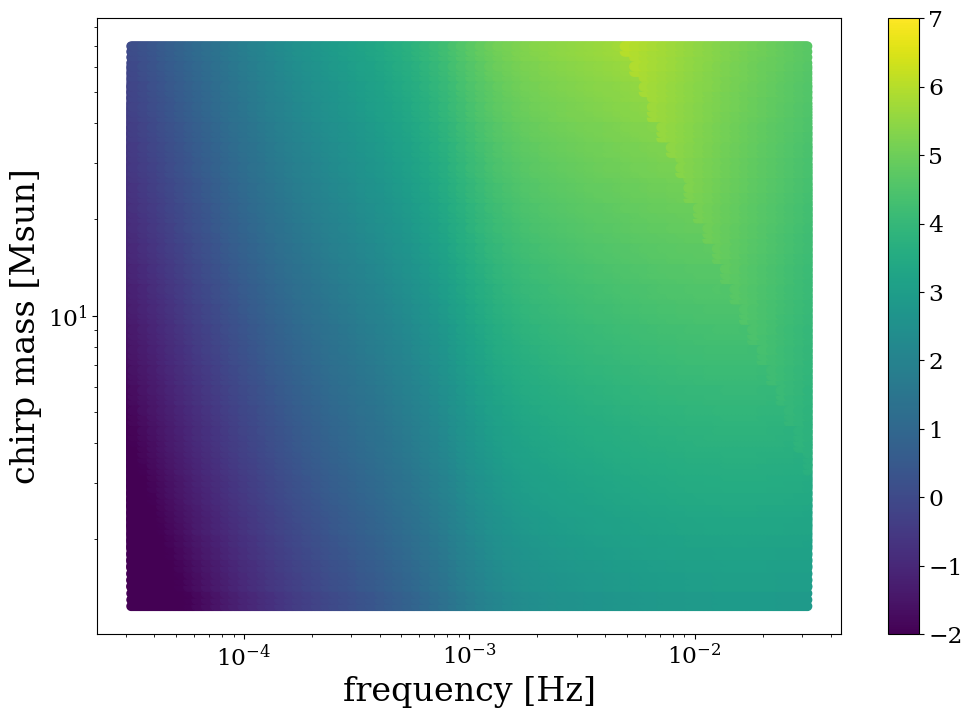

0.005954754497342746


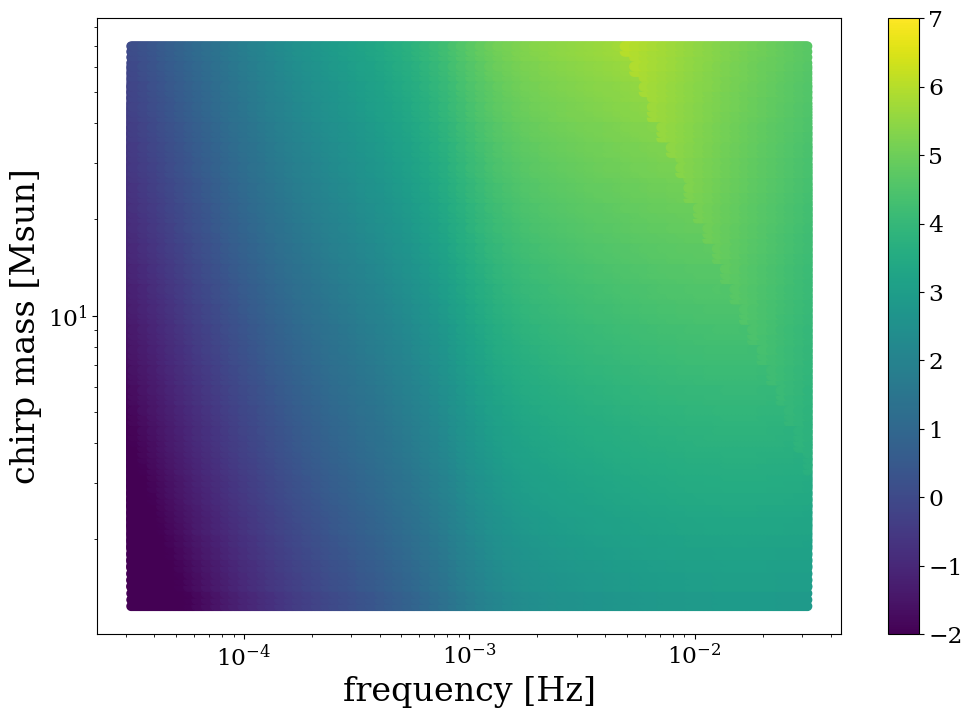

0.035459101123623694


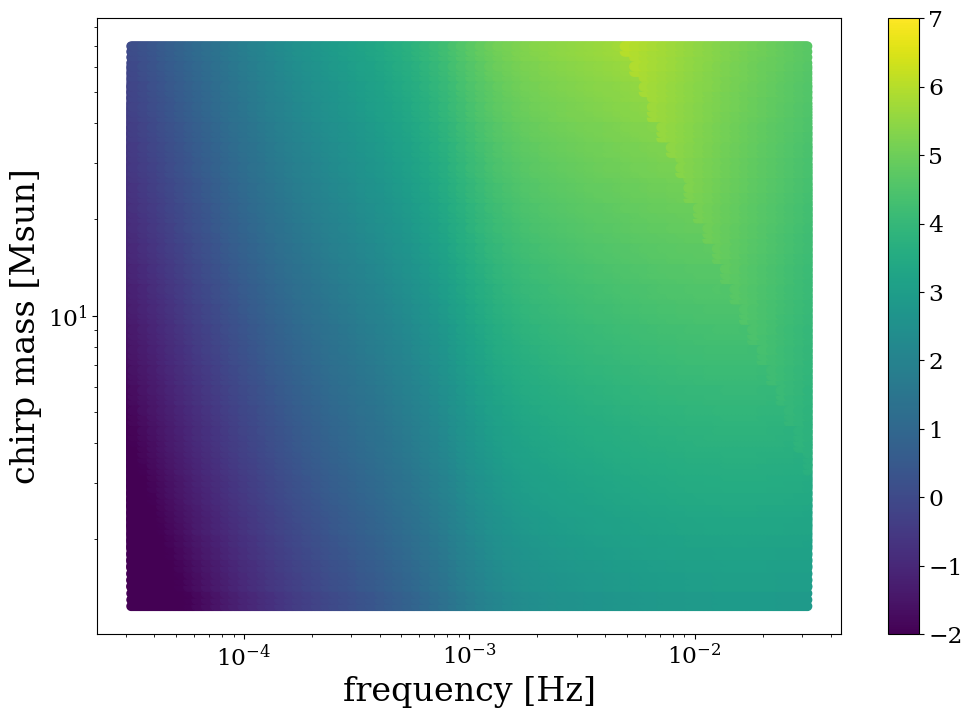

0.21115024188762943


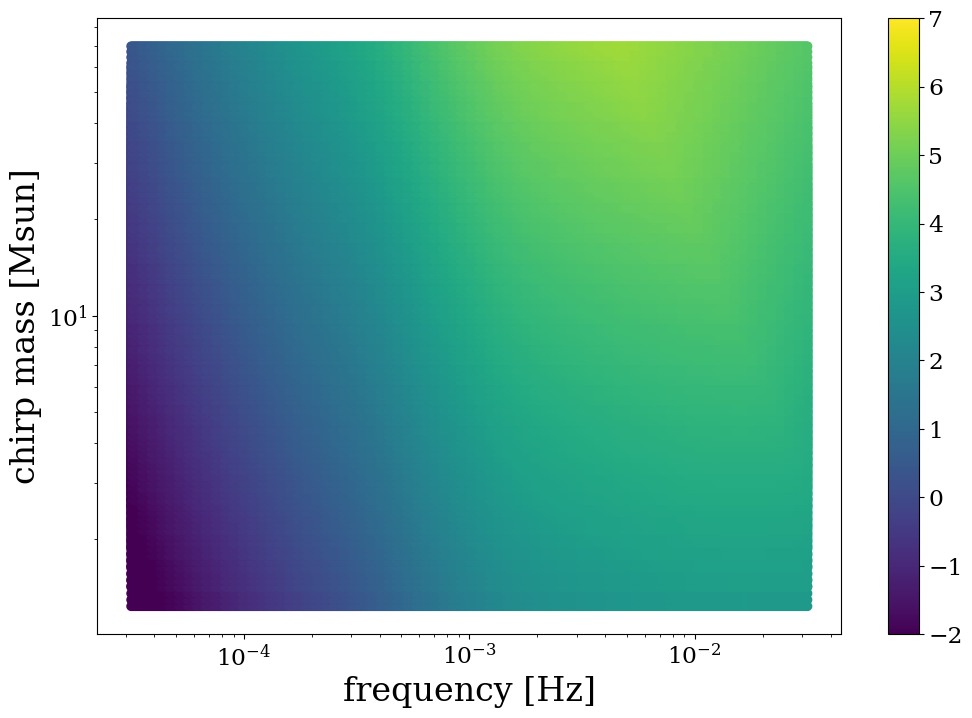

In [21]:
for ii in range(len(e_grid_test))[::5]:
    print(e_grid_test[ii])
    plt.scatter(F_T[:,:,ii,:], MC_T[:,:,ii,:], c=np.log10((D_H_T[:,:,ii,:] * u.Mpc).to(u.kpc).value), vmin=-2, vmax=7)
    plt.colorbar()
    plt.xscale('log')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('chirp mass [Msun]')
    plt.yscale('log')
    plt.show()

In [ ]:
e_grid_test[::2]